# Grover's search algorithm Implementation with Qiskit
## ELEC5210 Final Project
## Chan Chak Lam Jonathan
## cljchanac@connect.ust.hk
### May 03, 2021



In [1]:
import numpy as np
from qiskit import QuantumCircuit, Aer, execute
from qiskit.quantum_info import Operator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
%matplotlib inline

def oracle(noQubit, winners, name = "U$_o$"):
    qc= QuantumCircuit(noQubit, name=name)
    oracleNp=np.identity(2**noQubit, dtype=complex)
    for i in winners:
        oracleNp[i,i] = -1 #Turn the winner to -1
    oracle=Operator(oracleNp)
    qc.unitary(oracle, [i for i in range(noQubit)], label='Oracle')
    return qc
'''
def diffuser(noQubit, name = 'U$_f$'):
    qc = QuantumCircuit(noQubit, name = name)
    qc.h(range(noQubit))
    qc.append(oracle(noQubit,[0]),range(noQubit))
    qc.h(range(noQubit))
    return qc
'''
def diffuser(nqubits, name = 'U$_f$'):
    qc = QuantumCircuit(nqubits, name = name)
    qc.h(range(nqubits))
    qc.x(range(nqubits))

    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  #toffoli
    qc.h(nqubits-1)
    
    qc.x(range(nqubits))
    qc.h(range(nqubits))
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

def grover(noQubit, winners, loopTime=None):
    qc = QuantumCircuit(noQubit,noQubit)
    qc.h(range(noQubit))
    if loopTime==None:
        loopTime = int(np.ceil(np.sqrt(n/len(winners))))

    for i in range(loopTime):
        qc.append(oracle(noQubit,winners),range(noQubit))
        qc.append(diffuser(noQubit), range(noQubit))
    qc.measure(range(noQubit),range(noQubit))
    return qc


# Construct quantum circuit

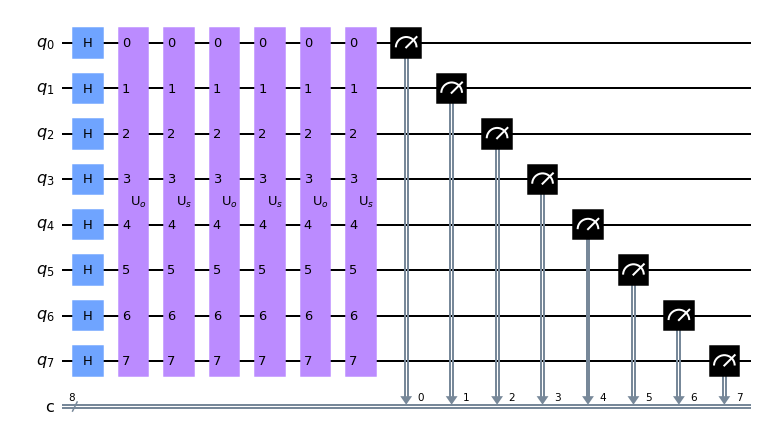

In [2]:
n = 8 #number of qubit
#x = int('01', 2)
winners = [10] #Winner(s) list
qc = grover(n, winners)
#qc.draw()
fig, ax = plt.subplots(ncols=1, figsize=(15,6))
qc.draw(output='mpl', ax=ax)
#fig.savefig('result/circuit'+str(n)+'qb_'+str(winner)+'win.png')

## Simulate quantum circuit

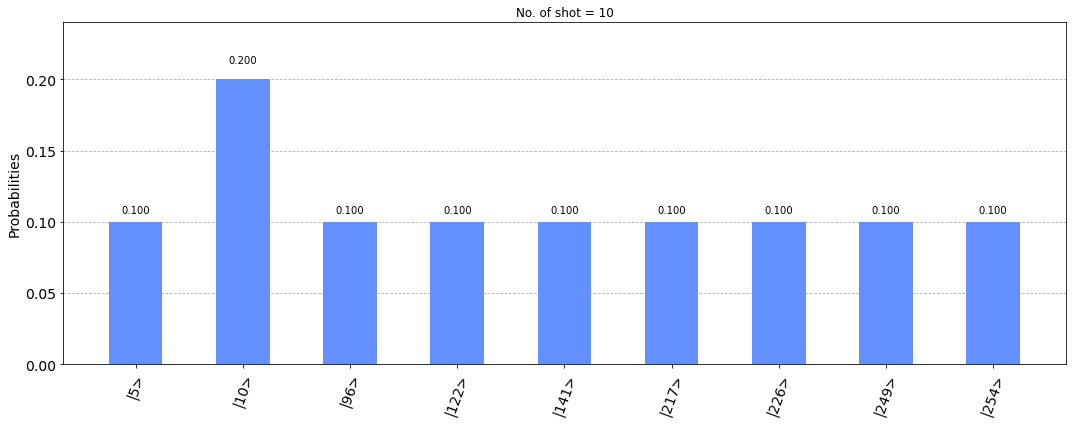

In [3]:
backend = Aer.get_backend('qasm_simulator')
myshot=10
result = execute(qc, backend, shots=myshot).result()
counts = result.get_counts(qc)
fig, ax = plt.subplots(ncols=1, figsize=(15,6))

plot_histogram(counts, ax=ax)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = ['|'+str(int(lab,2))+'>' for lab in labels]
ax.set_xticklabels(labels)
ax.set_title("No. of shot = "+ str(myshot))
fig.tight_layout()
#fig.savefig('result/result'+str(n)+'qb_'+str(winner)+'win.png')
#fig.savefig('result/result'+str(n)+'qb_'+str(winner)+'win.png')

# Further study
## Different Grover iteration

In [ ]:
backend = Aer.get_backend('qasm_simulator')

mycols = 10
myrows = 10

n = 8
#x = int('01', 2)
winners = [8]
myProb = []
plt.close('all')
fig, ax = plt.subplots(nrows=myrows,ncols=mycols, figsize=(15,10))
myshot=1
j=0
for i in range(0,mycols*myrows):
    qc = grover(n, winners,i+1)
    result = execute(qc, backend, shots=10).result()
    counts = result.get_counts(qc)
    '''
    plot_histogram(counts, ax=ax[j,i%mycols])
    labels = [item.get_text() for item in ax[j,i%mycols].get_xticklabels()]
    labels = ['|'+str(int(lab,2))+'>' for lab in labels]
    ax[j,i%mycols].set_xticklabels(labels)
    ax[j,i%mycols].set_title("No. of Iteration = "+ str(i+1))
    '''
    if i!=0 and i%mycols==(mycols-1):
        j=j+1
    if '{0:08b}'.format(n) not in counts:
        myProb.append(0)
    else:
        myProb.append(float(counts['{0:08b}'.format(n)])/sum(counts.values()))
fig.tight_layout()

#fig.savefig('result/result'+str(n)+'qb_'+str(winner)+'win.png')
#fig.savefig('result/result'+str(n)+'qb_'+str(winner)+'win.png')



In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(10,5))
ax.plot(myProb)
ax.set_ylabel('Probability')
ax.set_xlabel('Grover Iteration')
ax.set_xlim([0,len(myProb)])
ax.set_ylim([0,1])
ax.grid()

# Further study
## Different Shot

In [ ]:
backend = Aer.get_backend('qasm_simulator')

mycols = 4
myrows = 2
plt.close('all')
fig, ax = plt.subplots(nrows=myrows,ncols=mycols, figsize=(15,10))
shotArry=[1,2,4,8,16,32,64,128]
myshot=1
j=0
for i in range(0,mycols*myrows):
    
    result = execute(qc, backend, shots=shotArry[i]).result()
    counts = result.get_counts(qc)
    plot_histogram(counts, ax=ax[j,i%mycols])
    labels = [item.get_text() for item in ax[j,i%mycols].get_xticklabels()]
    labels = ['|'+str(int(lab,2))+'>' for lab in labels]
    ax[j,i%mycols].set_xticklabels(labels)
    ax[j,i%mycols].set_title("No. of shot = "+ str(shotArry[i]))
    if i!=0 and i%mycols==(mycols-1):
        j=j+1
fig.tight_layout()

#fig.savefig('result/result'+str(n)+'qb_'+str(winner)+'win.png')
#fig.savefig('result/result'+str(n)+'qb_'+str(winner)+'win.png')